# Chronic Kidney Disease Detection

#### Summary
* It is a classification problem
* Features include numerical values and categorical values
* Need to impute missing numerical values
* Need to impute missing categorical values
* Categorical features need to convert to numerical (get_dummies or DictVectorizer)
* DictVectorizer is introduced
* Pipeline build

#### dataset source
* The chronic kidney disease dataset contains both categorical and numeric features, but contains lots of missing values. The goal here is to predict who has chronic kidney disease given various blood indicators as features.</p>
* The dataset can be download from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease)

#### Package
* There are 3 self defined package: 
    * missing_values_table: check the percetage of missing values and turn it into a table
    * Categorical_Imputer: imputing categorical missing values using the most frequent
    * roc_auc: plot roc curve

## Library

In [6]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# Ipython tool for figsize
from IPython.core.pylabtools import figsize

# train test split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline

# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

# XGB
import xgboost as xgb

# cross_val_score
from sklearn.model_selection import cross_val_score

# DataframeMapper, CategoricalImputer
from sklearn_pandas import *
from sklearn_pandas import DataFrameMapper

# Imputer
from sklearn.preprocessing import *

# FeatureUnion
from sklearn.pipeline import FeatureUnion

# Function Transformer
from sklearn.preprocessing import FunctionTransformer

# ROC AUC
from sklearn.metrics import roc_auc_score, roc_curve

In [5]:
!pip install sklearn_pandas

In [7]:
class Categorical_Imputer:
    """
    Imputing categorical data using the most frequent value
    """
    
    # instance attribute
    def __init__(self, strategy):
        self.strategy = strategy
        
    # instance method
    def fit_transform(self, df:'dataframe')->'dataframe':
        """
        Fill in missing categorical values using most frequent value
        """
        
        # instantiate CategoricalImputer
        imputer = CategoricalImputer()
        
        # convert array to dataframe
        df_filled = df.apply(lambda x: imputer.fit_transform(x), axis=0)
        
        # return filled dataframe
        return df_filled

# Function to calculate missing values by column
def missing_values_table(df):
   
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    # .iloc[:, 1]!= 0: filter on missing missing values not equal to zero
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)  # round(2), keep 2 digits
    
    # Print some summary information
    print("Your slelected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

class roc_auc:
    """
    Calculate AUC score, Plot ROC curve
    """
    
    # instance attribute
    def __init__(self, y_test, y_pred_prob, model='model'):
        self.y_test = y_test
        self.y_pred_prob = y_pred_prob
        self.model = model
        
    # instance method
    def auc(self):
        """
        calculate auc score
        """
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        
        return auc_score
        
    # instance method
    def plot_roc(self):
        """
        plot roc curve
        """
        # AUC score
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        
        # fpr, tpr, threshold
        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred_prob)
        
        # ROC curve plot
        _ = plt.plot([0, 1], [0, 1], 'k--')
        _ = plt.plot(fpr, tpr, label= self.model + ' Classifier (AUC = {: .2f})'.format(auc_score))
        _ = plt.xlabel('False Positive Rate')
        _ = plt.ylabel('True Positive Rate')
        _ = plt.legend(loc='lower right')
        _ = plt.title(self.model + ' Classifier ROC Curve')
        _ = plt.show()

# $\rm I.$ Data Preparation
In this section, we load the data, inspect missing values, convert data type, convert target to numerical

## Load Data

In [8]:
# set display columns
pd.set_option('display.max_columns', 30)

In [9]:
# load data
df = pd.read_csv('datasets/chronic_kidney_disease.csv', header=None, 
                 names=['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 
                           'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class'])

# head of df
df.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,36,1.2,?,?,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,18,0.8,?,?,11.3,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,?,?,9.6,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,?,?,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
5,60,90,1.015,3,0,?,?,notpresent,notpresent,74,25,1.1,142,3.2,12.2,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,68,70,1.010,0,0,?,normal,notpresent,notpresent,100,54,24.0,104,4.0,12.4,36,?,?,no,no,no,good,no,no,ckd
7,24,?,1.015,2,4,normal,abnormal,notpresent,notpresent,410,31,1.1,?,?,12.4,44,6900,5,no,yes,no,good,yes,no,ckd
8,52,100,1.015,3,0,normal,abnormal,present,notpresent,138,60,1.9,?,?,10.8,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


Columns explain:
* age		-	age	
* bp		-	blood pressure
* sg		-	specific gravity
* al		-   albumin
* su		-	sugar
* rbc		-	red blood cells
* pc		-	pus cell
* pcc		-	pus cell clumps
* ba		-	bacteria
* bgr		-	blood glucose random
* bu		-	blood urea
* sc		-	serum creatinine
* sod		-	sodium
* pot		-	potassium
* hemo	    -	hemoglobin
* pcv		-	packed cell volume
* wc		-	white blood cell count
* rc		-	red blood cell count
* htn		-	hypertension
* dm		-	diabetes mellitus
* cad		-	coronary artery disease
* appet	    -	appetite
* pe		-	pedal edema
* ane		-	anemia
* class	    -	class	

## Exporatory Data Analysis

In [10]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     400 non-null    object
 1   bp      400 non-null    object
 2   sg      400 non-null    object
 3   al      400 non-null    object
 4   su      400 non-null    object
 5   rbc     400 non-null    object
 6   pc      400 non-null    object
 7   pcc     400 non-null    object
 8   ba      400 non-null    object
 9   bgr     400 non-null    object
 10  bu      400 non-null    object
 11  sc      400 non-null    object
 12  sod     400 non-null    object
 13  pot     400 non-null    object
 14  hemo    400 non-null    object
 15  pcv     400 non-null    object
 16  wc      400 non-null    object
 17  rc      400 non-null    object
 18  htn     400 non-null    object
 19  dm      400 non-null    object
 20  cad     400 non-null    object
 21  appet   400 non-null    object
 22  pe      400 non-null    ob

* All columns have dtype object, no matter categorial columns or numerical columns.
* We can see there are some missing values in ?, but pandas does not regard it as missing values.

#### Replace ? with Null

In [11]:
# repace ? values
df.replace('?', np.nan, inplace=True)

df.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,NaN,normal,notpresent,notpresent,121,36,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,18,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
5,60,90,1.015,3,0,NaN,NaN,notpresent,notpresent,74,25,1.1,142,3.2,12.2,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,68,70,1.010,0,0,NaN,normal,notpresent,notpresent,100,54,24.0,104,4.0,12.4,36,NaN,NaN,no,no,no,good,no,no,ckd
7,24,NaN,1.015,2,4,normal,abnormal,notpresent,notpresent,410,31,1.1,NaN,NaN,12.4,44,6900,5,no,yes,no,good,yes,no,ckd
8,52,100,1.015,3,0,normal,abnormal,present,notpresent,138,60,1.9,NaN,NaN,10.8,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


In [12]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     391 non-null    object
 1   bp      388 non-null    object
 2   sg      353 non-null    object
 3   al      354 non-null    object
 4   su      351 non-null    object
 5   rbc     248 non-null    object
 6   pc      335 non-null    object
 7   pcc     396 non-null    object
 8   ba      396 non-null    object
 9   bgr     356 non-null    object
 10  bu      381 non-null    object
 11  sc      383 non-null    object
 12  sod     313 non-null    object
 13  pot     312 non-null    object
 14  hemo    348 non-null    object
 15  pcv     329 non-null    object
 16  wc      294 non-null    object
 17  rc      269 non-null    object
 18  htn     398 non-null    object
 19  dm      398 non-null    object
 20  cad     398 non-null    object
 21  appet   399 non-null    object
 22  pe      399 non-null    ob

#### Check missing value percentage

In [13]:
# missing value table
missing_values_table(df)

Your slelected dataframe has 25 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
rbc,152,38.00
rc,131,32.75
wc,106,26.50
pot,88,22.00
sod,87,21.75
pcv,71,17.75
pc,65,16.25
hemo,52,13.00
su,49,12.25
sg,47,11.75


#### Convert to Numeric

In [14]:
# numerical columns
num_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

In [15]:
# categorical columns
cate_cols = df.columns.drop('class').drop(num_cols)
# display categorical columns
cate_cols

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [16]:
# convert numerical data 
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [17]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wc      294 non-null    float64
 17  rc      269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

#### Categorical Feature Unique Values

In [18]:
# categorical columns
cate_cols = df.columns.drop('class').drop(num_cols)
# display categorical columns
cate_cols

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [19]:
# check the number of unique values
df[cate_cols].apply(lambda x: x.nunique(), axis=0)

rbc      2
pc       2
pcc      2
ba       2
htn      2
dm       3
cad      2
appet    2
pe       2
ane      2
dtype: int64

In [20]:
# Problem found on df['dm'], string has extra space
df['dm'].unique()

array(['yes', 'no', ' yes', nan], dtype=object)

In [21]:
df['dm'].dtype

dtype('O')

In [22]:
# delete the space
df['dm'] = df['dm'].str.strip()

**If not delete this extra space, an error will be caused in pipeline due to X_train and X_test dimension not match!**

#### Convert target into 0 and 1

In [23]:
# convert categorical target to numerical
df['class'] = df['class'].apply(lambda x: 1 if x=='ckd' else 0)

# show the head of df['class']
df['class'].head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [24]:
# X and y
X = df.drop(columns=['class'])
y= df['class']

In X, we have missing values for both numerical and categorical data.

# $\rm II.$ Sklearn Imputer and Pandas Get Dummies Approach
In this section, we use sklearn Imputer to impute missing numerical and categorical missing values. We use pandas getdummies to turn categorical values into numerical values.

In [25]:
# load X and y
X = df.drop(columns=['class'])
y= df['class']

## Imputing Data

In [26]:
# define numerical imputer
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')

In [27]:
# imputing on numerical data
X[num_cols] = num_imputer.fit_transform(X[num_cols])

In [28]:
# define categorical imputer
cate_imputer = SimpleImputer(strategy="most_frequent") 

In [29]:
# imputing on categorical data
X[cate_cols] = cate_imputer.fit_transform(X[cate_cols])

In [30]:
# X head
X.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
5,60.0,90.0,1.015,3.0,0.0,normal,normal,notpresent,notpresent,74.0,25.0,1.1,142.0,3.2,12.2,39.0,7800.0,4.4,yes,yes,no,good,yes,no
6,68.0,70.0,1.010,0.0,0.0,normal,normal,notpresent,notpresent,100.0,54.0,24.0,104.0,4.0,12.4,36.0,8000.0,4.8,no,no,no,good,no,no
7,24.0,80.0,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,31.0,1.1,138.0,4.4,12.4,44.0,6900.0,5.0,no,yes,no,good,yes,no
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,60.0,1.9,138.0,4.4,10.8,33.0,9600.0,4.0,yes,yes,no,good,no,yes
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,yes,yes,no,poor,no,yes


In [31]:
# missing value table
missing_values_table(X)

Your slelected dataframe has 24 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Get dummies
Turn categorical feature into numerical values

In [32]:
# Get dummies
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)

# X head
X.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,rbc_normal,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,1,1,0,0,1,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,1,1,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,1,1,0,0,0,1,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1,0,1,0,1,0,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,1,1,0,0,0,0,0,0,0,0


In [33]:
# X shape
X.shape

(400, 24)

## RandomForestClassifier

In [34]:
# Instantiate RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_cl = RandomForestClassifier()

In [35]:
# cross validation score
cv_scores = cross_val_score(rf_cl, X, y, scoring='roc_auc', cv=3)

In [36]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 0.9992780646395104


## Fit Model

In [37]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [38]:
# fit the model
rf_cl.fit(X_train, y_train)

RandomForestClassifier()

## ROC AUC Curve

In [39]:
# predict on the test set
y_pred_prob = rf_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [40]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='RF')

In [41]:
# AUC score
ROC.auc()

0.9982222222222222

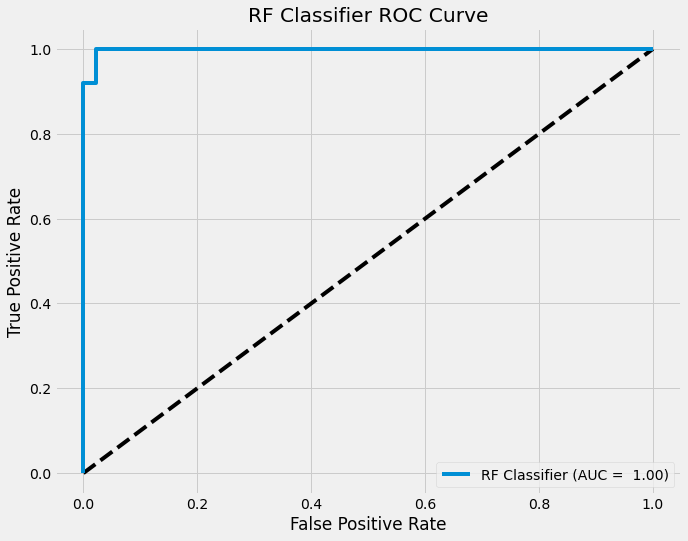

In [42]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

# XGBClassifier

In [43]:
# Instantiate XGBClassifier
xgb_cl = xgb.XGBClassifier()

In [44]:
# cross validation score
cv_scores = cross_val_score(xgb_cl, X, y, scoring='roc_auc', cv=3)

In [45]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 0.998156435264869


## Fit Model

In [46]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [47]:
# fit the model
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## ROC AUC Curve

In [48]:
# predict on the test set
y_pred_prob = xgb_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [49]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='XGB')

In [50]:
# AUC score
ROC.auc()

0.9961481481481482

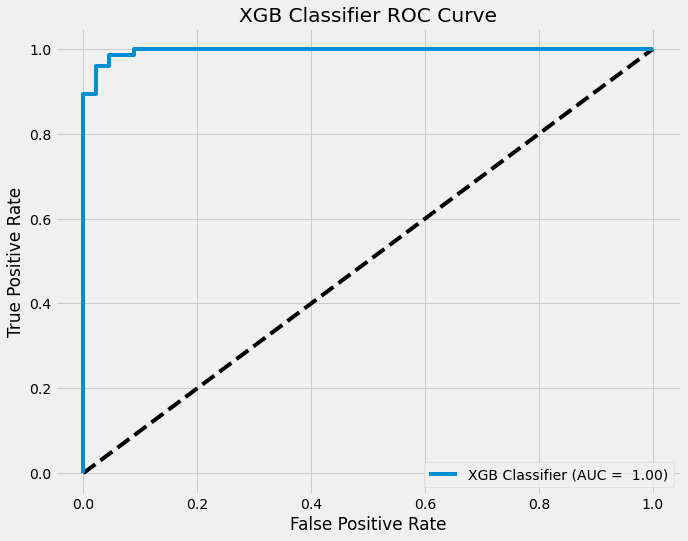

In [51]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

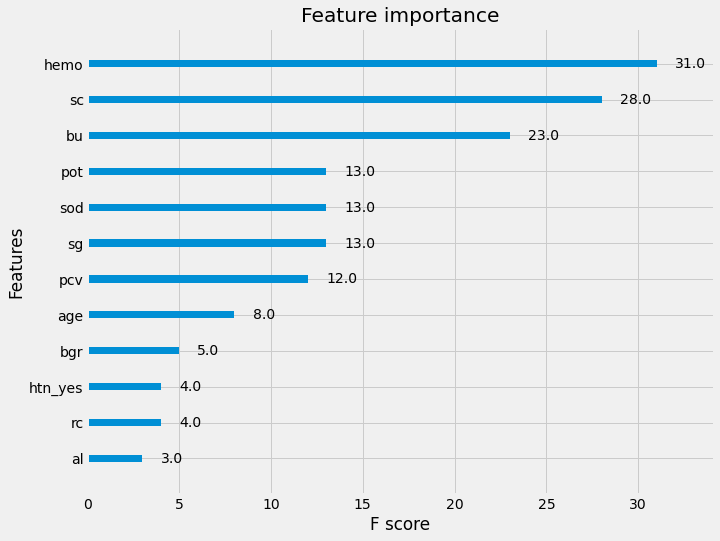

In [52]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot feature importance
xgb.plot_importance(xgb_cl)

# CatBoostClassifier

In [55]:
# Instantiate CatBoostClassifier
from catboost import CatBoostClassifier
cbc_cl = CatBoostClassifier()

In [54]:
!pip install catboost

In [56]:
# cross validation score
cv_scores = cross_val_score(cbc_cl, X, y, scoring='roc_auc', cv=3)

Learning rate set to 0.005853
0:	learn: 0.6833620	total: 138ms	remaining: 2m 17s
1:	learn: 0.6744971	total: 139ms	remaining: 1m 9s
2:	learn: 0.6649067	total: 141ms	remaining: 46.9s
3:	learn: 0.6571738	total: 143ms	remaining: 35.7s
4:	learn: 0.6487533	total: 145ms	remaining: 28.8s
5:	learn: 0.6403155	total: 147ms	remaining: 24.3s
6:	learn: 0.6312621	total: 148ms	remaining: 21s
7:	learn: 0.6230431	total: 150ms	remaining: 18.6s
8:	learn: 0.6159905	total: 152ms	remaining: 16.7s
9:	learn: 0.6072801	total: 153ms	remaining: 15.2s
10:	learn: 0.5992802	total: 155ms	remaining: 13.9s
11:	learn: 0.5918273	total: 157ms	remaining: 12.9s
12:	learn: 0.5841777	total: 158ms	remaining: 12s
13:	learn: 0.5755661	total: 159ms	remaining: 11.2s
14:	learn: 0.5672387	total: 161ms	remaining: 10.6s
15:	learn: 0.5600184	total: 163ms	remaining: 10s
16:	learn: 0.5520261	total: 164ms	remaining: 9.51s
17:	learn: 0.5445106	total: 166ms	remaining: 9.05s
18:	learn: 0.5381520	total: 168ms	remaining: 8.65s
19:	learn: 0.530

In [57]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 0.9996796710652133


## Fit Model

In [58]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [59]:
# fit the model
cbc_cl.fit(X_train, y_train)

Learning rate set to 0.005982
0:	learn: 0.6818621	total: 1.73ms	remaining: 1.73s
1:	learn: 0.6734495	total: 3.59ms	remaining: 1.79s
2:	learn: 0.6635224	total: 5.54ms	remaining: 1.84s
3:	learn: 0.6552197	total: 7.58ms	remaining: 1.89s
4:	learn: 0.6456054	total: 10.2ms	remaining: 2.02s
5:	learn: 0.6375213	total: 13ms	remaining: 2.16s
6:	learn: 0.6284100	total: 15.5ms	remaining: 2.2s
7:	learn: 0.6201377	total: 17.9ms	remaining: 2.22s
8:	learn: 0.6129724	total: 19.4ms	remaining: 2.14s
9:	learn: 0.6038016	total: 21.2ms	remaining: 2.1s
10:	learn: 0.5953104	total: 23.1ms	remaining: 2.08s
11:	learn: 0.5871101	total: 25ms	remaining: 2.06s
12:	learn: 0.5804819	total: 27.1ms	remaining: 2.05s
13:	learn: 0.5708344	total: 29.3ms	remaining: 2.06s
14:	learn: 0.5628463	total: 30.9ms	remaining: 2.03s
15:	learn: 0.5565945	total: 32.7ms	remaining: 2.01s
16:	learn: 0.5482055	total: 34.5ms	remaining: 1.99s
17:	learn: 0.5407740	total: 36.1ms	remaining: 1.97s
18:	learn: 0.5332605	total: 38.1ms	remaining: 1.97

## ROC AUC Curve

In [60]:
# predict on the test set
y_pred_prob = cbc_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [61]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='CatBoostClassifier')

In [62]:
# AUC score
ROC.auc()

0.9988148148148148

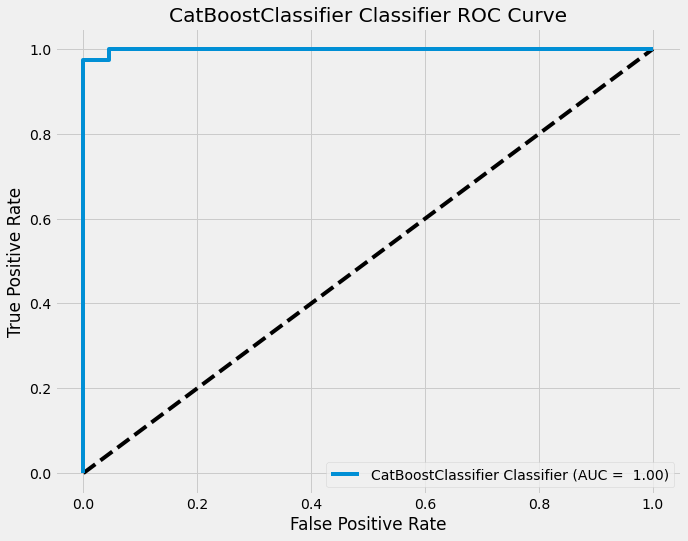

In [63]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

In [64]:
!pip install lightgbm

# LGBMClassifier

In [65]:
# Instantiate LGBMClassifier
from lightgbm import LGBMClassifier
lgbm_cl = LGBMClassifier()

In [66]:
# cross validation score
cv_scores = cross_val_score(lgbm_cl, X, y, scoring='roc_auc', cv=3)

In [67]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 1.0


## Fit Model

In [68]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [69]:
# fit the model
lgbm_cl.fit(X_train, y_train)

LGBMClassifier()

## ROC AUC Curve

In [70]:
# predict on the test set
y_pred_prob = lgbm_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [71]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='LGBMClassifier')

In [72]:
# AUC score
ROC.auc()

0.9991111111111112

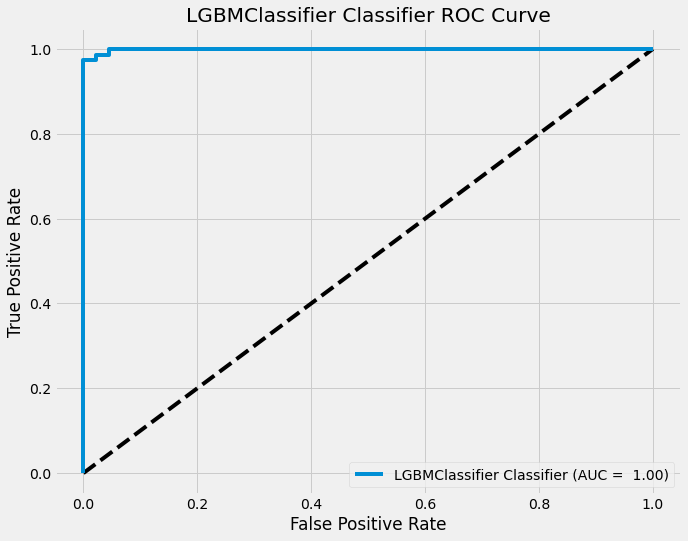

In [73]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()